In [1]:
!pip install -q addict
!pip install -q segmentation-models-pytorch

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensor
import segmentation_models_pytorch as smp
from tqdm import tqdm
import os
import logging
import numpy as np
import wandb
from addict import Dict
import warnings
import seaborn as sns
import matplotlib.pyplot as plt


warnings.simplefilter("ignore")
logging.basicConfig(format="[%(asctime)s][%(levelname)s] - %(message)s")

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [4]:
config = Dict({
    "images_path": "../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset",
})

train_config = Dict({
    "project": "Fish Semantic Segmentation",
    "output_path": "model.onnx",
    "batch_size": 16,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "epochs": 10,
    
    "model": {
        "type": "UNet",
        "parameters": {
            "encoder_name": "resnet34",
            "in_channels": 3,
        }
    },
    
    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.01,
        }
    },
    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
        }
    },
    
    "input_size": (256, 256),
    "augmentations": A.Compose([
                                A.Downscale(scale_min=0.5, scale_max=0.75, p=0.2),
                                A.HorizontalFlip(p=0.5),
                                A.Blur(p=0.2),
                                A.VerticalFlip(p=0.5),
                                A.RandomFog(p=0.2),
                                A.RandomBrightness(p=0.2),
                                A.RandomBrightnessContrast(p=1), 
                                A.RandomGamma(p=0.7),
                                ToTensor(),
    ]),
    "num_workers": 4,
})

In [5]:
def train_test_split(dataset, test_size=0.2):
    length = len(dataset)
    train_length = round(length * (1 - test_size))
    test_length = length - train_length
    
    train_dataset, test_dataset = random_split(dataset, [train_length, test_length])
    return train_dataset, test_dataset

In [6]:
import nibabel as nib
import os
from PIL import Image
import numpy as np

def save_as_image(data, output_path):
    print(data.shape)
    image = Image.fromarray(data)
    print("ok")
    image.save(output_path)

def resize_and_convert(slice_data):
    resized_slice = Image.fromarray(slice_data).resize((256,256), Image.ANTIALIAS)
    rgb_slice = np.array(resized_slice)[:, :, np.newaxis]
    rgb_slice = np.repeat(rgb_slice, 3, axis=2)
    return rgb_slice
def resize_and_convert_mask(slice_data):
    resized_slice = Image.fromarray(slice_data).resize((256,256), Image.ANTIALIAS)
    #rgb_slice = np.array(resized_slice)[:, :, np.newaxis]
    return np.array(resized_slice)


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from PIL import Image
from sklearn.model_selection import train_test_split

In [8]:
# Define paths and output directories
data_directory = '/kaggle/input/cerebrovascular-segmentation/data/'
main_output_dir = '/kaggle/working/main_img/'
mask_output_dir = '/kaggle/working/mask/'

if not os.path.exists(main_output_dir):
    os.makedirs(main_output_dir)
if not os.path.exists(mask_output_dir):
    os.makedirs(mask_output_dir)

# Iterate through patient folders
patient_folders = [folder for folder in os.listdir(data_directory) if folder.startswith('Normal_')]


In [9]:
images=[]
masks=[]
prefix_to_remove = 'Normal_'
x=0
for patient_folder in patient_folders:

    i = patient_folder.replace(prefix_to_remove, '')
    
    main_image_path = os.path.join(data_directory, patient_folder, 'img_'+i+'.nii')
    label_path = os.path.join(data_directory, patient_folder,'label_'+i+'.nii')
    main_image = nib.load(main_image_path).get_fdata()
    label = nib.load(label_path).get_fdata()
    
    for slice_idx in range(main_image.shape[2]):
        #print(slice_idx)
        slice_img = resize_and_convert(main_image[:, :, slice_idx]).astype(np.uint8)
       
        slice_mask = resize_and_convert_mask(label[:, :, slice_idx])#.astype(np.bool_)
#         if x<2:
#             plt.imshow(slice_mask)
#             plt.axis('off')  # Turn off axis labels
#             plt.title('Image from Array')
#             plt.show()
        images.append(slice_img)
        
        masks.append(slice_mask)
        
#         # Process and save main image
#         main_output_path = os.path.join(main_output_dir, f'{patient_folder}_{x}.png')
#         #print(main_output_path)
#         save_as_image(slice_img, main_output_path)
        
#         # Process and save label (mask)
#         mask_output_path = os.path.join(mask_output_dir, f'{patient_folder}_{x}.png')
#         save_as_image(slice_mask, mask_output_path)
#         if x>200:
#             break
        x=x+1

print("Extraction and conversion completed.")


Extraction and conversion completed.


In [10]:
images=np.asarray(images)
masks= np.asarray(masks)

In [11]:
print(images.shape,masks.shape)

(5376, 256, 256, 3) (5376, 256, 256)


In [12]:
class FishDataset(Dataset):
    def __init__(self, images, masks, augmentations=None, size=(512, 512)):
        self.images = images
        self.masks = masks
        self.__size = size
        self.__augmentations = augmentations
        
                
    def __len__(self):
        return self.images.shape[0]
    
    def load_image(self, image):
        width, height = self.__size
        loader = A.Compose([
            A.Resize(width=width, height=height),
        ])
        
        
        #print(image.shape)
        return loader(image=image)["image"]
    
    def __getitem__(self, index):
        if index <= self.images.shape[0]:
            image = self.load_image(images[index])
            mask = self.load_image(masks[index])
            if self.__augmentations is not None:
                augmentated = self.__augmentations(image=image, mask=mask)
                return Dict(augmentated)
            
            return Dict({
                "image": image,
                "mask": mask,
            })

In [13]:
dataset = FishDataset(images,masks,
                      augmentations=train_config.augmentations,
                      size=train_config.input_size)

In [14]:
item = dataset[0]
item.mask.shape

torch.Size([1, 256, 256])

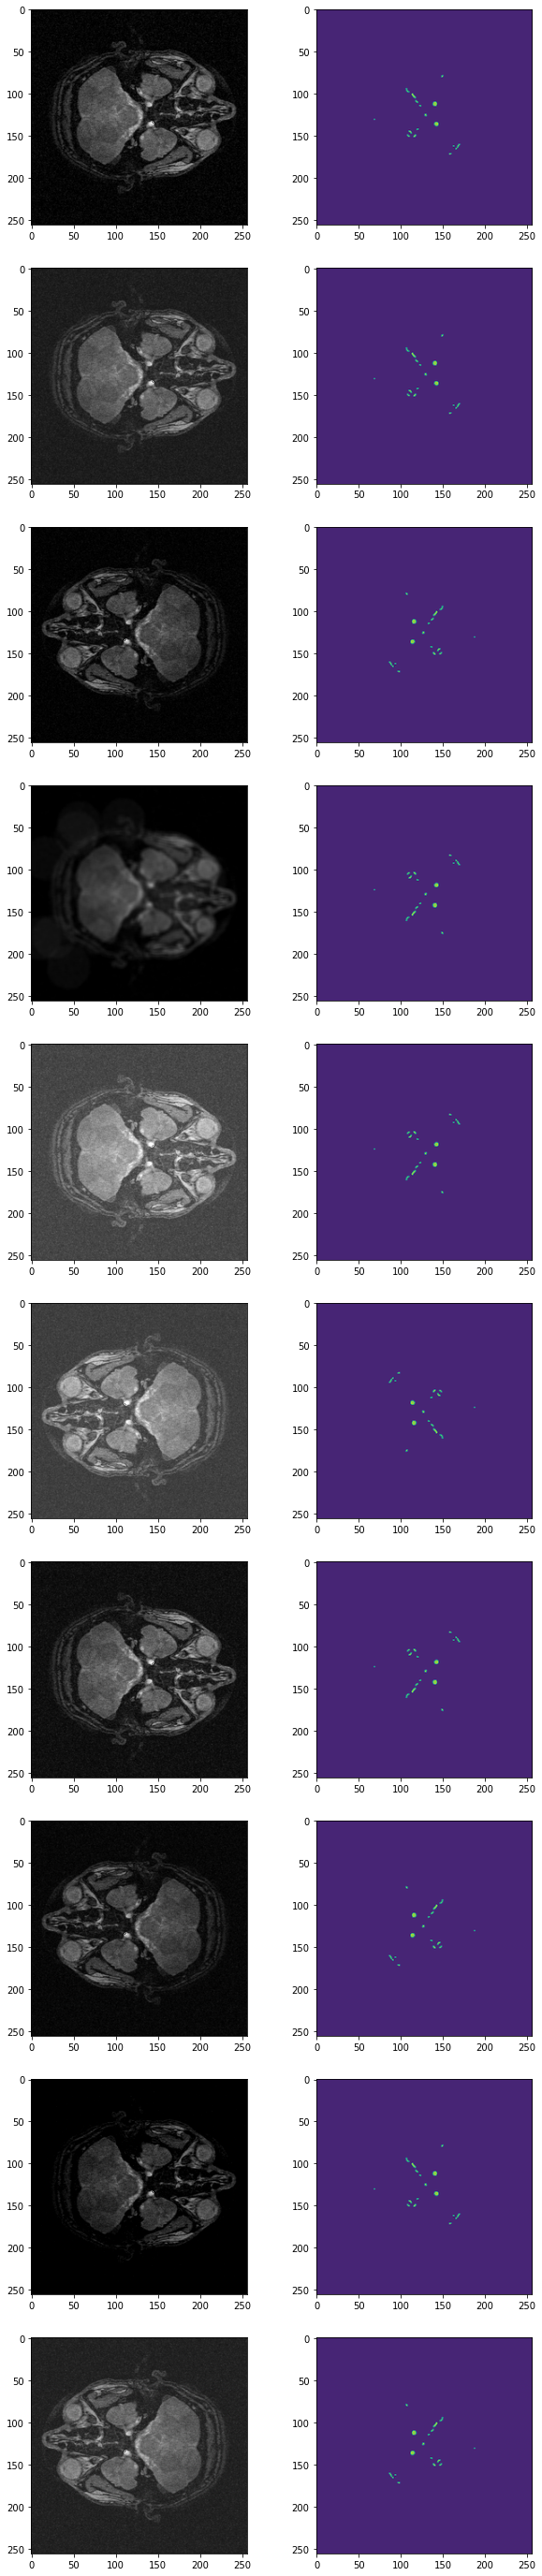

In [15]:
fig, axes = plt.subplots(10, 2, figsize=(10, 50))
for i in range(10):
    item = dataset[0]
        
    axes[i, 0].imshow(item.image.permute(1, 2, 0).numpy().reshape(256, 256, 3))
    axes[i, 1].imshow(item.mask.numpy().reshape(256, 256))

In [16]:
train_dataset, test_dataset = train_test_split(dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=train_config.batch_size,
                          num_workers=train_config.num_workers,
                          pin_memory=True,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=train_config.batch_size*2,
                         num_workers=train_config.num_workers,
                         pin_memory=True,
                         shuffle=False)

In [17]:
class Trainer:
    def __init__(self, model, criterion, optimizer, project, output_path, scheduler=None, config={}, device="cpu"):
        self.__model = model
        self.__criterion = criterion
        self.__optimizer = optimizer
        self.__scheduler = scheduler,
        self.__project = project
        self.__device = device
        self.__output_path = output_path
        self.__config = config
        
    def evaluate(self, loader):
        self.__model.to(self.__device)
        loader_length = len(loader)
        loss = 0
        with torch.no_grad():
            for batch in loader:
                torch.cuda.empty_cache()
                
                images = batch["image"].to(self.__device)
                masks = batch["mask"].cpu()
                
                outputs = model(images).cpu()
                batch_loss = self.__criterion(outputs, masks)
                loss += batch_loss.item()
            
        loss /= loader_length
        return loss
    
    def fit(self, loader, validation_loader=None, epochs=10):
        with wandb.init(project=self.__project, config=self.__config):
            wandb.watch(self.__model, self.__criterion, log="all")
            self.__model.to(self.__device)
            loader_length = len(loader)
            for epoch in range(epochs):
                loop = tqdm(loader)
                loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
                epoch_loss = 0
                for batch in loop:
                    torch.cuda.empty_cache()
                    self.__optimizer.zero_grad()

                    images = batch["image"].to(self.__device)
                    masks = batch["mask"].cpu()

                    outputs = self.__model(images).cpu()
                    batch_loss = self.__criterion(outputs, masks)

                    epoch_loss += batch_loss.item()
                    loop.set_postfix(loss=batch_loss.item())

                    batch_loss.backward()
                    self.__optimizer.step()



                epoch_loss /= loader_length
                loop.set_postfix(loss=epoch_loss)
                wandb.log({"loss": epoch_loss}, step=epoch+1)

                if validation_loader is not None:
                    validation_loss = self.evaluate(validation_loader)
                    loop.set_postfix(validation_loss=validation_loss)
                    wandb.log({"validation_loss": validation_loss}, step=epoch+1)

                    if self.__scheduler is not None:
                        scheduler.step(validation_loss)
                        lr = optimizer.state_dict()["param_groups"][0]["lr"]
                        wandb.log({"lr": lr}, step=epoch+1)
                else:
                    if self.__scheduler is not None:
                        scheduler.step()
                        lr = optimizer.state_dict()["param_groups"][0]["lr"]
                        wandb.log({"lr": lr}, step=epoch+1)
                        
            torch.onnx.export(model, images, self.__output_path)
            wandb.save(self.__output_path)

In [18]:
if train_config.model.type == "UNet":
    model = smp.Unet(**train_config.model.parameters)
    
if train_config.criterion == "BCE":
    criterion = nn.BCEWithLogitsLoss()

if train_config.optimizer.type == "AdamW":
    optimizer = AdamW(model.parameters(), **train_config.optimizer.parameters)
    
    
if "scheduler" in train_config:
    if train_config.scheduler.type == "ReduceLROnPlateau":
        scheduler = ReduceLROnPlateau(optimizer, **train_config.scheduler.parameters)
else:
    scheduler = None
    
trainer = Trainer(model,
                  
                  optimizer=optimizer,
                  criterion=nn.BCEWithLogitsLoss(),
                  scheduler=scheduler,
                  device=train_config.device,
                  project=train_config.project,
                  output_path=train_config.output_path,
                  config=train_config)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [19]:
trainer.fit(loader=train_loader, validation_loader=test_loader, epochs=train_config.epochs)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  


wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
Epoch [10/10]: 100%|██████████| 252/252 [01:23<00:00,  3.01it/s, loss=0.00995]


loss,0.00976
validation_loss,0.00948
lr,0.01
_runtime,932
_timestamp,1694762085
_step,10


loss,█▂▂▂▁▁▁▁▁▁
validation_loss,█▅▄▄▃▂▂▂▂▁
lr,▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▃▄▄▅▆▇██
_timestamp,▁▂▃▄▄▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█


wandb: You can sync this run to the cloud by running:
wandb: wandb sync /kaggle/working/wandb/offline-run-20230915_065912-2t3idlty


In [20]:
test_loss = trainer.evaluate(test_loader)
test_loss

0.00948226558310645

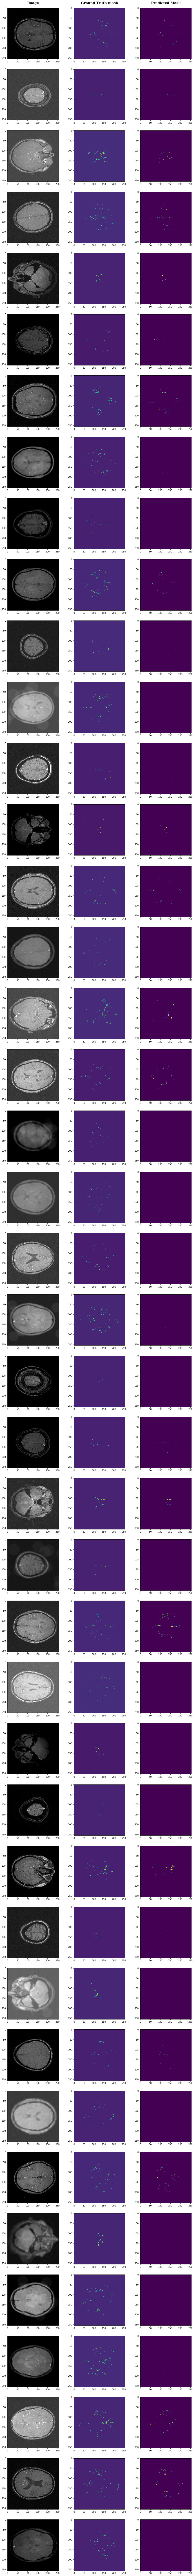

In [21]:
model.to(train_config.device)

test_length = len(test_loader)

fig, axes = plt.subplots(test_length, 3, figsize=(3*5, test_length * 5))
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        torch.cuda.empty_cache()
                
        images = batch["image"].to(train_config.device)
        masks = batch["mask"].cpu()
                
        outputs = model(images).cpu()
        
        image, mask, predicted_mask = images.cpu()[0].permute(1, 2, 0).numpy(), masks[0].permute(1, 2, 0).numpy(), outputs[0].permute(1, 2, 0).numpy()
        binary_predicted_mask = np.where(predicted_mask > 0.5, 1, 0)
        
        image_ax, mask_ax, predicted_mask_ax = axes[idx, 0], axes[idx, 1], axes[idx, 2]
        
        image_ax.imshow(image)
        mask_ax.imshow(mask)
        predicted_mask_ax.imshow(binary_predicted_mask)
        
        
        if idx == 0:
            image_ax.set_title("Image", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
            mask_ax.set_title("Ground Truth mask", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
            predicted_mask_ax.set_title("Predicted Mask", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
        
        
fig.show()